As doenças cardiovasculares são as maiores causadoras de mortes no Brasil e no Mundo. Os fatores que aumentam os riscos são conhecidos e bastante estudados. O desenvolvimento e ferramentas que utilizam o aprendizado de máquina contribuem para o desenvolvimento de diagnósticos mais corretos e predições assertivas, permitindo a o tratamento precoce e até mesmo a prevenção dessas doenças.
Aqui, fizemos uma predição de doenças cardiovasculares utilizando o algoritmo XGBoost.

In [1]:
#Importando Biliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
#carregando dataset
data = pd.read_csv('heart.csv')

In [3]:
#verificando as 5 primeiras linhas
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
#Verificando o número de linhas e colunas
data.shape

(303, 14)

In [5]:
#Verificando a quantidade de vazios
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [6]:
#Verificando o tipo das variáveis
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [7]:
#Correlação
corr = data.corr()

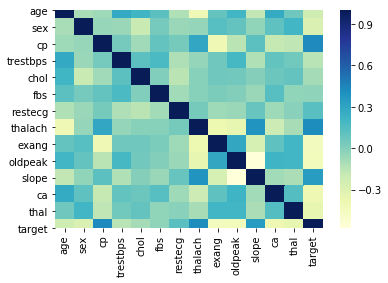

In [8]:
ax = sns.heatmap(corr, cmap="YlGnBu")
plt.rcParams['figure.figsize'] = (30,30)
plt.show()

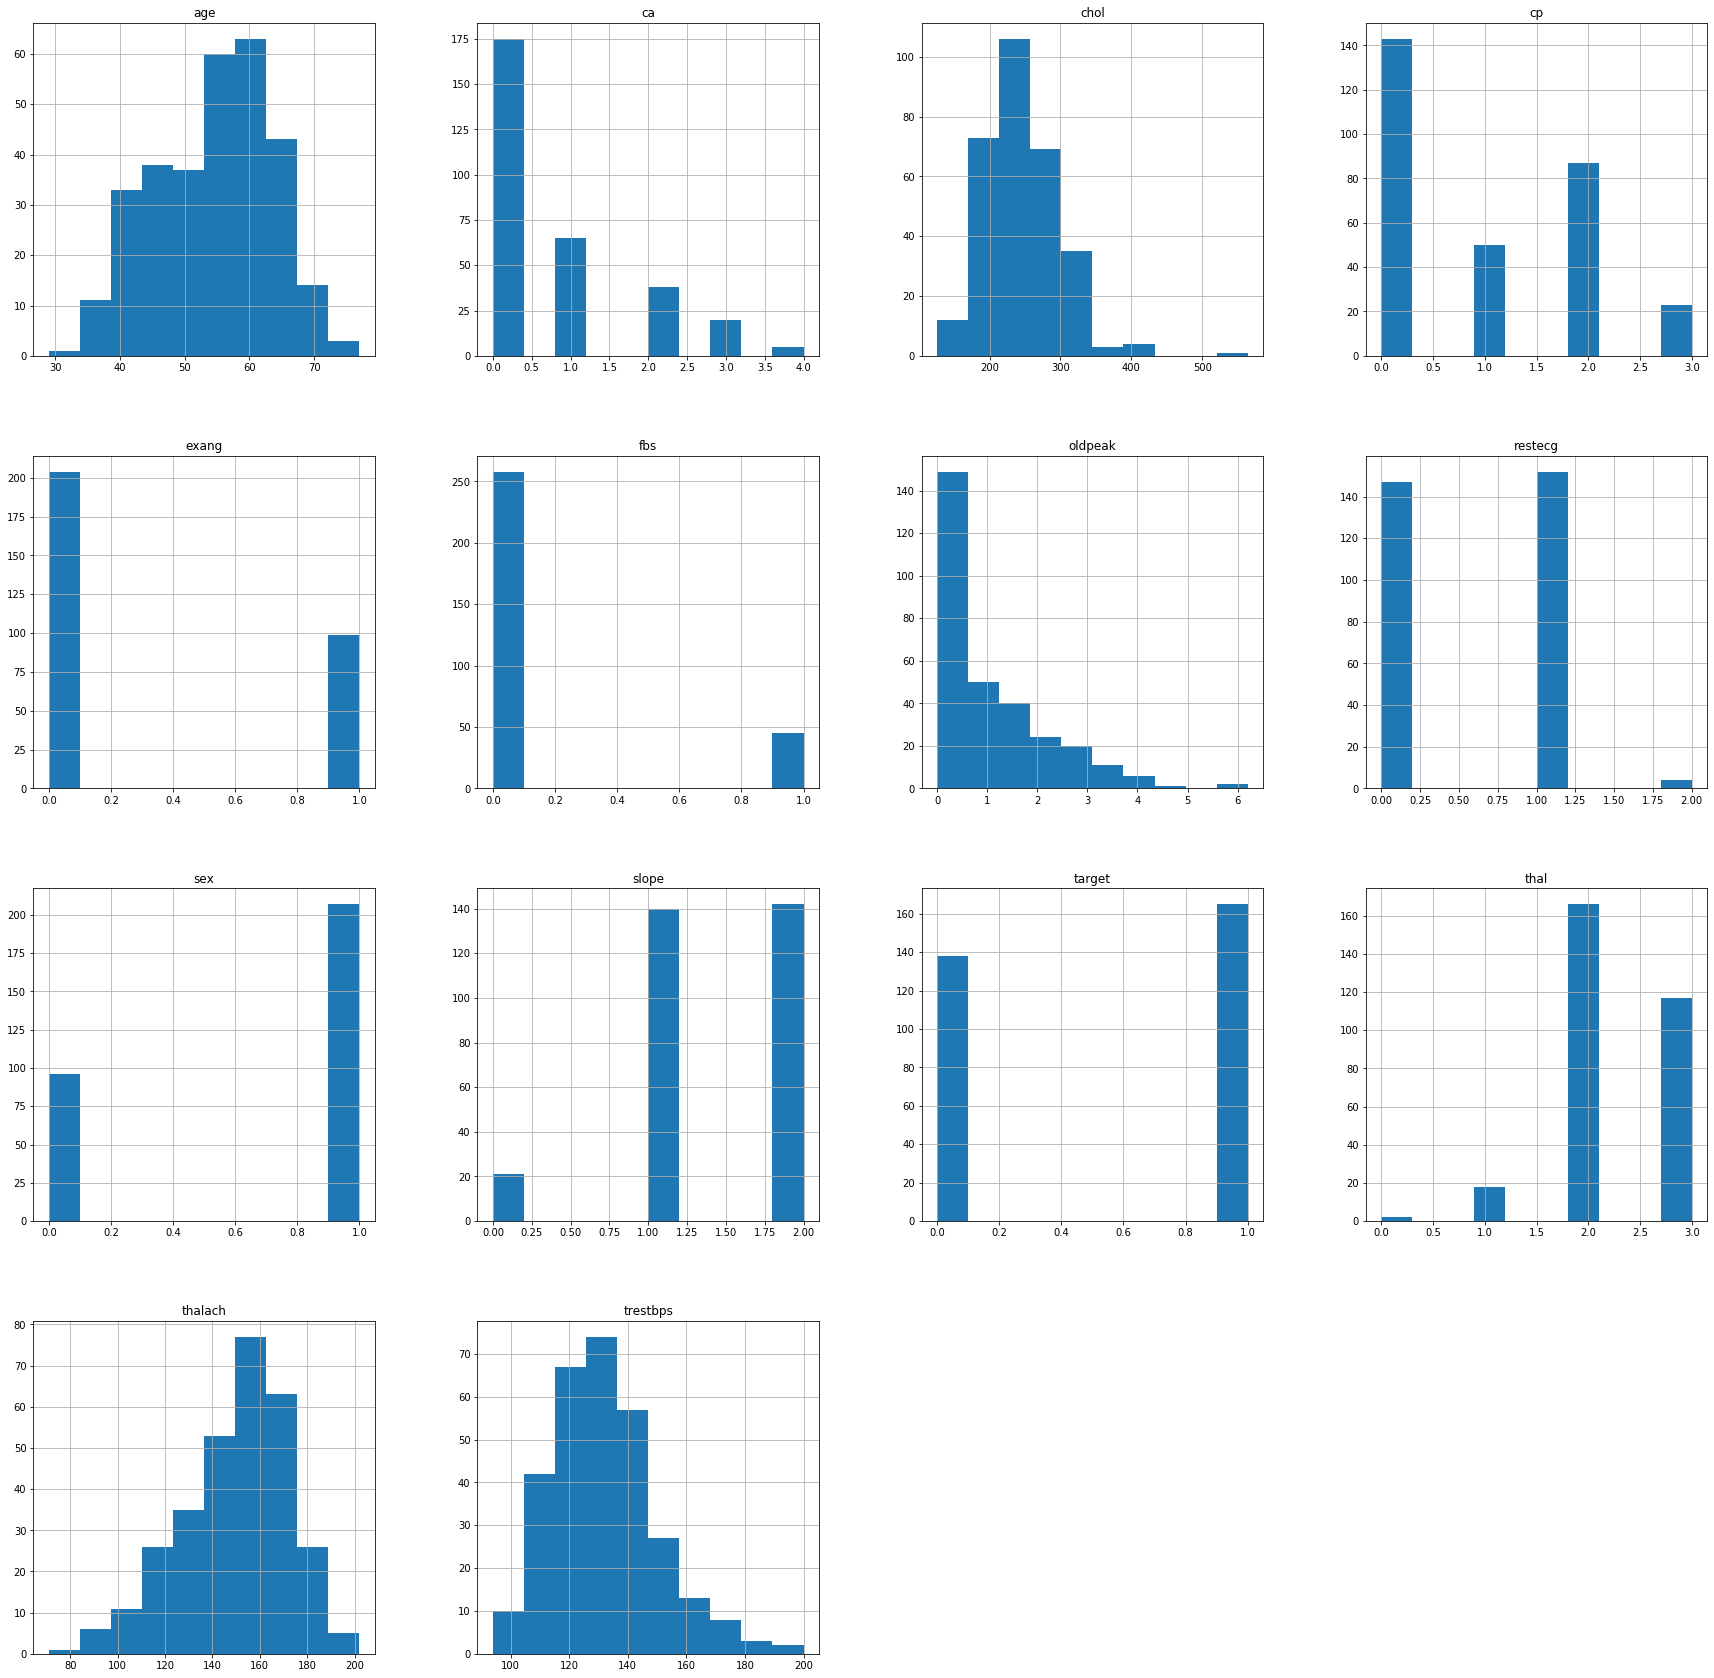

In [9]:
#Verificando comportamentos
data.hist()
plt.show()

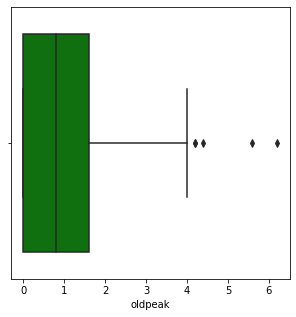

In [10]:
#Outliers
plt.figure(figsize=(5,5))
sns.boxplot(data.oldpeak, color = 'green')


In [11]:
data.drop('thal', axis = 1, inplace = True)

In [12]:
#Separando variáveis e target
X = data.iloc[:,:12]
Y = data.iloc[:,12]


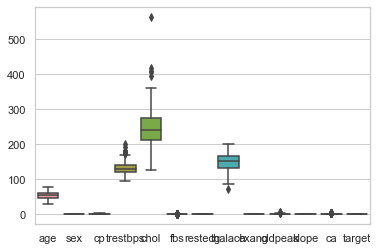

In [13]:
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.boxplot(data=data);

Class 0: 138
Class 1: 165
Proportion: 0.84 : 1


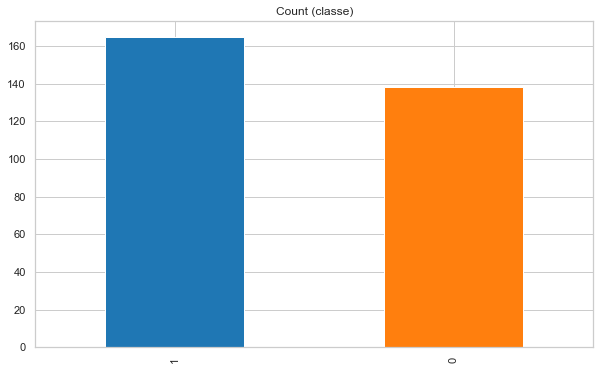

In [14]:
#Verificando as classes para ver se não estão desbalanceadas
target_count = data.target.value_counts()
plt.figure(figsize=(10,6))
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', title='Count (classe)',color = ['#1F77B4', '#FF7F0E']);

In [15]:
#Função - retirando outliers
def out(n):
    mean = np.mean(n, axis=0)
    sd = np.std(n, axis=0)

    for x in n:
        if (x < mean - 2*sd):
             print(x)

In [16]:
out(data['chol'])

141
126
131


In [17]:
out(data['ca'])

In [18]:
out(data['oldpeak'])

In [19]:
#Arrumando o desbalanceamento
from imblearn.under_sampling import RandomUnderSampler
# Number of data points in the minority class
number_records_f= len(data[data.target == 0])
f_indices = np.array(data[data.target == 0].index)

# Picking the indices of the normal classes
normal_indices = data[data.target == 1].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_f)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([f_indices,random_normal_indices])


# Under sample dataset
under_sample_data = data.loc[under_sample_indices,:]

X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'target']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'target']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.sex == 1])/len(under_sample_data))
print("Percentage of f transactions: ", len(under_sample_data[under_sample_data.sex == 0])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))


Using TensorFlow backend.


Percentage of normal transactions:  0.7065217391304348
Percentage of f transactions:  0.29347826086956524
Total number of transactions in resampled data:  276


In [20]:
# Divisão dos dados em treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_undersample, y_undersample,test_size = 0.2, random_state = 42)

In [21]:
X_train.shape, X_test.shape

((220, 12), (56, 12))

In [22]:
y_train.shape,y_test.shape

((220, 1), (56, 1))

O XGBoost é um excelente algoritmo para análise de dados estruturados, que utiliza o Gradiente boosting. Ele foi criando na Universidade de Washington nos EUA. Trata-se de uma ferramenta poderosa de árvores de decisão que pode ser usada tanto em casos de regressão como de classificação. Ele é muito eficiente e flexível. Realizaremos a análise utilizando-o.

In [23]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

modelo_xg = xgb.XGBClassifier(learning_rate = 0.01, 
                              max_depth = 2, 
                              n_estimators = 1000,
                             min_child_weight = 5,
                             gamma = 0.1,
                             reg_alpha=1,
                            reg_lambda=1.5)
modelo_xg.fit(X_train,y_train)    
resultado2 = modelo_xg.predict_proba(X_test)[:,1]
valores_previstos2 = modelo_xg.predict(X_test)
score = roc_auc_score(y_test, resultado2)
score

/home/jfs/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jfs/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9642857142857143

In [24]:
feature_imp = pd.Series(modelo_xg.feature_importances_,index=X.columns).sort_values(ascending=False)

In [25]:
def visualiza_features_importantes(features_lista):
    %matplotlib inline

    plt.figure(figsize=(16,8))
    sns.barplot(x=features_lista, y=features_lista.index )

    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.show()



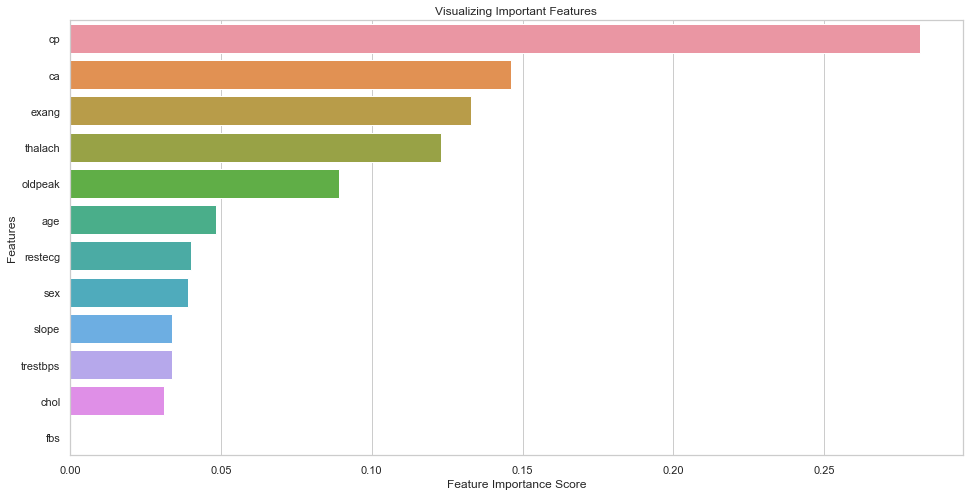

In [26]:
#Verificando os pesos de cada variável na predição
visualiza_features_importantes(feature_imp)


In [27]:
feature_imp

cp          0.281764
ca          0.146230
exang       0.132940
thalach     0.123092
oldpeak     0.089279
age         0.048386
restecg     0.040265
sex         0.039091
slope       0.033845
trestbps    0.033835
chol        0.031272
fbs         0.000000
dtype: float32

In [28]:
#Limitando as variáveis para observar o comportamento.
features_selecionadas = []
for feature,importancia in feature_imp.iteritems():
    if   importancia > 0.09 :
        print("{}:\t{}".format(feature, importancia))
        features_selecionadas.append(feature)

cp:	0.28176429867744446
ca:	0.14622977375984192
exang:	0.13294021785259247
thalach:	0.12309161573648453


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X[features_selecionadas],
    Y,
    test_size=0.2,
    random_state=42
)

In [30]:
modelo_xg = xgb.XGBClassifier(learning_rate = 0.001, 
                              max_depth = 2, 
                              n_estimators = 1000,
                             min_child_weight = 5,
                             gamma = 0.1,
                             reg_alpha=1,
                            reg_lambda=1.5)
modelo_xg.fit(X_train,y_train)    
resultado2 = modelo_xg.predict_proba(X_test)[:,1]
valores_previstos2 = modelo_xg.predict(X_test)
score = roc_auc_score(y_test, resultado2)
score

0.8814655172413792

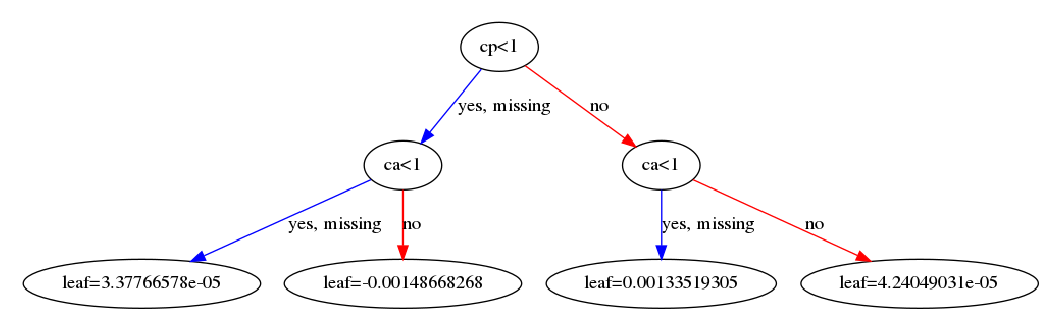

In [31]:
from xgboost import plot_tree



# plot single tree
fig = plt.figure(dpi=180)
ax = plt.subplot(1,1,1)
plot_tree(modelo_xg, num_trees=4, ax = ax)
 
plt.tight_layout()
plt.savefig("tree_structure.pdf")
plt.show()